In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy.random as npr
import logistic_svd.simpletqdm
logistic_svd.simpletqdm.tqdm_type='notebook'
import tqdm
import types

import matplotlib.pylab as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let 

$$\Gamma_{cg} = \sum_k \alpha_{gk} z_{ck}$$
$$L = \sum_{cg} (X_{cg}-.5)\Gamma_{cg} - \log 2 \cosh \Gamma_{cg}/2$$
$$R_\alpha = \sum_{g} -.5\alpha^T D_\alpha \alpha + \alpha^T d_\alpha$$
$$R_z = \sum_{c} -.5z^T D_z z + z^T d_z$$

Goal is to maximize $L+R_\alpha +R_z$ as a funciton of $z,\alpha$.


# example (with numpy)

In [64]:
import logistic_svd.numpy_version # <-- slow but doesn't need torch

In [65]:
# generate some simulated data
Nc=900
Ng=800
Nk=2
z=npr.randn(Nc,Nk)
alpha=npr.randn(Ng,Nk)
data = npr.rand(Nc,Ng) < (1 / (1+np.exp(-z@alpha.T)))

truelik=logistic_svd.numpy_version.logistic_likelihood(data,z,alpha)

In [68]:
def train(data,z_guess,alpha_guess):
    '''
    An example training function.  Tweak to suit.
    '''

    # train
    liks=[]
    for i in tqdm.tqdm_notebook(range(20)):
        # get current objective value
        liks.append(logistic_svd.numpy_version.logistic_likelihood(data,z_guess,alpha_guess))

        # update alpha
        alpha_guess= logistic_svd.numpy_version.update_alpha(data,z_guess,alpha_guess)

        # get current objective value
        liks.append(logistic_svd.numpy_version.logistic_likelihood(data,z_guess,alpha_guess))

        # update z (the problem is symmetric; just update alpha on the transpose...)
        z_guess= logistic_svd.numpy_version.update_alpha(data.T,alpha_guess,z_guess)

    # get final objective
    liks.append(logistic_svd.numpy_version.logistic_likelihood(data,z_guess,alpha_guess))
    return z_guess,alpha_guess,liks


In [79]:
def plot_accuracy(z,alpha,z_guess,alpha_guess):
    '''
    This gives one way of assessing how well the learned model did at 
    learning the original parameters.  
    '''
    estimated_logits = z_guess @ alpha_guess.T
    true_logits = z@alpha.T

    # plot a subset of the logits (truth vs estimated)
    perm=npr.permutation(np.prod(true_logits.shape))[:1000]
    plt.scatter(true_logits.ravel()[perm],estimated_logits.ravel()[perm],alpha=.1)

    MX1=np.abs(true_logits.ravel()[perm]).max()
    MX2=np.abs(estimated_logits.ravel()[perm]).max()
    MX=np.max([MX1,MX2])
    plt.plot([-MX,MX],[-MX,MX],'r-',label='perfect fit')
    plt.xlabel("true logit")
    plt.ylabel("estimates")
    plt.title('logits for each entry')
    plt.legend()


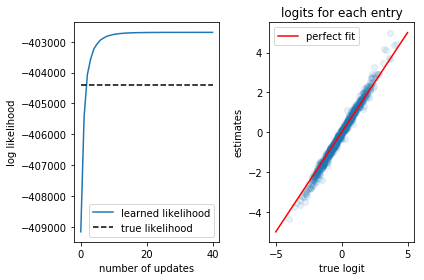

In [69]:
# try training using SVD as an initialziation
# do we get something good?

# a place to store the results
numpy_results = types.SimpleNamespace()

# initialize
numpy_results.z_init,numpy_results.alpha_init=logistic_svd.numpy_version.initialize(data,Nk)

# train
numpy_results.z_final,numpy_results.alpha_final,numpy_results.liks=\
    train(data,numpy_results.z_init,numpy_results.alpha_init)

# plot convergence 
plt.subplot(1,2,1)
plt.plot(numpy_results.liks,label='learned likelihood')
plt.plot(np.ones(len(liks))*truelik,'k--',label='true likelihood')
plt.xlabel("number of updates")
plt.ylabel("log likelihood")
plt.legend()

# plot accuracy
plt.subplot(1,2,2)
plot_accuracy(z,alpha,numpy_results.z_final,numpy_results.alpha_final)

plt.tight_layout()

Two things to notice.  First, we don't get a perfect fit on the logits.  Second, we obtain a likelihood which is HIGHER THAN THE TRUTH.  This is because of overfitting.

# torch

We can do the same thing with torch.

In [70]:
import torch
import logistic_svd.torch_version # <-- can use GPU

# if you have a GPU, change this to 'cuda'
device='cpu'

# send data to torch
datat=torch.tensor(np.require(data,dtype=np.uint8),device=device,dtype=torch.uint8)

In [87]:
def train(data,z_guess,alpha_guess,n_iter):
    '''
    An example training function for torch code.  Tweak to suit.
    '''

    # train
    liks=[]
    for i in tqdm.tqdm_notebook(range(n_iter)):
        # get current objective value
        liks.append(logistic_svd.torch_version.logistic_likelihood(data,z_guess,alpha_guess))

        # update alpha
        alpha_guess= logistic_svd.torch_version.update_alpha(data,z_guess,alpha_guess)

        # get current objective value
        liks.append(logistic_svd.torch_version.logistic_likelihood(data,z_guess,alpha_guess))

        # update z (the problem is symmetric; just update alpha on the transpose...)
        z_guess= logistic_svd.torch_version.update_alpha(data.t(),alpha_guess,z_guess)

    # get final objective
    liks.append(logistic_svd.torch_version.logistic_likelihood(data,z_guess,alpha_guess))
    return z_guess,alpha_guess,liks


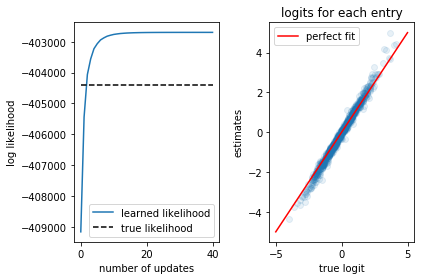

In [72]:
torch_results=types.SimpleNamespace()

# use the same initialization,
# do training on torch
z_guesst=torch.tensor(numpy_results.z_init,device=device)
alpha_guesst=torch.tensor(numpy_results.alpha_init,device=device)
z_guesst,alpha_guesst,liks=train(datat,z_guesst,alpha_guesst)

# send back to numpy land
torch_results.z_final=z_guesst.detach().cpu().numpy()
torch_results.alpha_final=alpha_guesst.detach().cpu().numpy()
torch_results.liks=liks

# plot convergence 
plt.subplot(1,2,1)
plt.plot(torch_results.liks,label='learned likelihood')
plt.plot(np.ones(len(liks))*truelik,'k--',label='true likelihood')
plt.xlabel("number of updates")
plt.ylabel("log likelihood")
plt.legend()

# plot accuracy
plt.subplot(1,2,2)
plot_accuracy(z,alpha,torch_results.z_final,torch_results.alpha_final)

plt.tight_layout()

# sanity check: torch and numpy give the same results:

In [73]:
print(np.abs(torch_results.z_final-numpy_results.z_final).max())
print(np.abs(torch_results.alpha_final-numpy_results.alpha_final).max())

8.43769498715119e-15
8.43769498715119e-15


# regularization

Regularization can sometimes help

In [85]:
# generate some simulated data
Nc=800
Ng=900
Nk=5
z=npr.randn(Nc,Nk)-3
alpha=npr.rand(Ng,Nk)
data = npr.rand(Nc,Ng) < (1 / (1+np.exp(-z@alpha.T)))

truelik=logistic_svd.numpy_version.logistic_likelihood(data,z,alpha)

# send data to torch
datat=torch.tensor(np.require(data,dtype=np.uint8),device=device,dtype=torch.uint8)

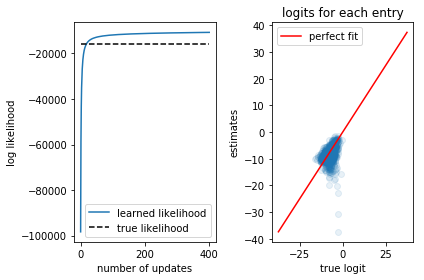

In [90]:
# UNREGULARIZED
torch_results=types.SimpleNamespace()

# initialization on numpy
z_init,alpha_init=logistic_svd.numpy_version.initialize(data,Nk)

# do training on torch
z_guesst=torch.tensor(z_init,device=device)
alpha_guesst=torch.tensor(alpha_init,device=device)
z_guesst,alpha_guesst,liks=train(datat,z_guesst,alpha_guesst,n_iter=200)

# send back to numpy land
torch_results.z_final=z_guesst.detach().cpu().numpy()
torch_results.alpha_final=alpha_guesst.detach().cpu().numpy()
torch_results.liks=liks

# plot convergence 
plt.subplot(1,2,1)
plt.plot(torch_results.liks,label='learned likelihood')
plt.plot(np.ones(len(liks))*truelik,'k--',label='true likelihood')
plt.xlabel("number of updates")
plt.ylabel("log likelihood")
plt.legend()

# plot accuracy
plt.subplot(1,2,2)
plot_accuracy(z,alpha,torch_results.z_final,torch_results.alpha_final)

plt.tight_layout()

Above we see that we sometimes estimate logits of like -40, where actually the true logits are never that small.  Some regularization can keep the logits sane.  Here we apply a quadratic penalty to the z and alpha loadings:

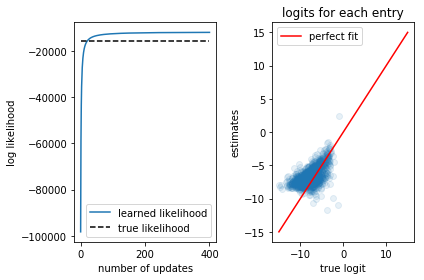

In [98]:
# REGULARIZED

def train_regularized(data,z_guess,alpha_guess,n_iter):
    '''
    An example training function for torch code.  Tweak to suit.
    '''

    # train
    liks=[]
    for i in tqdm.tqdm_notebook(range(n_iter)):
        # get current objective value
        liks.append(logistic_svd.torch_version.logistic_likelihood(data,z_guess,alpha_guess))

        # update alpha
        alpha_guess= logistic_svd.torch_version.update_alpha(data,z_guess,alpha_guess,reg_mtx=.6)

        # get current objective value
        liks.append(logistic_svd.torch_version.logistic_likelihood(data,z_guess,alpha_guess))

        # update z (the problem is symmetric; just update alpha on the transpose...)
        z_guess= logistic_svd.torch_version.update_alpha(data.t(),alpha_guess,z_guess,reg_mtx=.6)

    # get final objective
    liks.append(logistic_svd.torch_version.logistic_likelihood(data,z_guess,alpha_guess))
    return z_guess,alpha_guess,liks


torch_results=types.SimpleNamespace()

# initialization on numpy
z_init,alpha_init=logistic_svd.numpy_version.initialize(data,Nk)

# do training on torch
z_guesst=torch.tensor(z_init,device=device)
alpha_guesst=torch.tensor(alpha_init,device=device)
z_guesst,alpha_guesst,liks=train_regularized(datat,z_guesst,alpha_guesst,n_iter=200)

# send back to numpy land
torch_results.z_final=z_guesst.detach().cpu().numpy()
torch_results.alpha_final=alpha_guesst.detach().cpu().numpy()
torch_results.liks=liks

# plot convergence 
plt.subplot(1,2,1)
plt.plot(torch_results.liks,label='learned likelihood')
plt.plot(np.ones(len(liks))*truelik,'k--',label='true likelihood')
plt.xlabel("number of updates")
plt.ylabel("log likelihood")
plt.legend()

# plot accuracy
plt.subplot(1,2,2)
plot_accuracy(z,alpha,torch_results.z_final,torch_results.alpha_final)

plt.tight_layout()

# test consistency between torch and numpy versions

In [151]:
import numpy as np
import numpy.random as npr
import logistic_svd.simpletqdm
logistic_svd.simpletqdm.tqdm_type='notebook'
import tqdm
import types
import logistic_svd.numpy_version # <-- slow but doesn't need torch
import torch
import logistic_svd.torch_version # <-- can use GPU
device='cpu'


Nc=50
Ng=80
Nk=5
data=np.require(npr.randn(Nc,Ng)>.5,dtype=np.uint8)
datat=torch.tensor(data,device=device)

alpha=npr.randn(Ng,Nk)
z=npr.randn(Nc,Nk)

alphat=torch.tensor(alpha,device=device)
zt=torch.tensor(z,device=device)

In [152]:
A1=logistic_svd.torch_version.update_alpha(datat,zt,alphat,binsize=10).detach().cpu().numpy()
A2=logistic_svd.numpy_version.update_alpha(data,z,alpha)
print(np.abs(A1-A2).max())

6.661338147750939e-16


In [153]:
A1=logistic_svd.torch_version.update_alpha(datat,zt,alphat,reg_mtx=3.4,binsize=10).detach().cpu().numpy()
A2=logistic_svd.numpy_version.update_alpha(data,z,alpha,reg_mtx=3.4)
print(np.abs(A1-A2).max())

4.440892098500626e-16


In [154]:
reg_mtx = [npr.randn(Nk,Nk) for i in range(Ng)]
reg_mtx = [x@x.T for x in reg_mtx]
reg_mtx=np.array(reg_mtx)

reg_mtxt=torch.tensor(reg_mtx,device=device)

A1=logistic_svd.torch_version.update_alpha(datat,zt,alphat,reg_mtx=reg_mtxt,binsize=10).detach().cpu().numpy()
A2=logistic_svd.numpy_version.update_alpha(data,z,alpha,reg_mtx=reg_mtx)
print(np.abs(A1-A2).max())

5.551115123125783e-16


In [155]:
A1=logistic_svd.torch_version.logistic_likelihood(datat,zt,alphat)
A2=logistic_svd.numpy_version.logistic_likelihood(data,z,alpha)
print(np.abs(A1-A2))

9.094947017729282e-13


In [156]:
A1=logistic_svd.torch_version.quadratic(zt).detach().cpu().numpy()
A2=logistic_svd.numpy_version.quadratic(z)
print(np.abs(A1-A2).max())

0.0


In [157]:

A1=logistic_svd.torch_version.quadratic(zt,reg_mtx=3.0).detach().cpu().numpy()
A2=logistic_svd.numpy_version.quadratic(z,reg_mtx=3.0)
print(np.abs(A1-A2).max())

0.0


In [158]:

reg_mtx = [npr.randn(Nk,Nk) for i in range(Nc)]
reg_mtx = [x@x.T for x in reg_mtx]
reg_mtx=np.array(reg_mtx)

reg_mtxt=torch.tensor(reg_mtx,device=device)

A1=logistic_svd.torch_version.quadratic(zt,reg_mtx=reg_mtxt).detach().cpu().numpy()
A2=logistic_svd.numpy_version.quadratic(z,reg_mtx=reg_mtx)
print(np.abs(A1-A2).max())

1.4210854715202004e-14


In [159]:

reg_mtx = npr.randn(Nk,Nk)
reg_mtx = reg_mtx@reg_mtx.T

reg_mtxt=torch.tensor(reg_mtx,device=device)

A1=logistic_svd.torch_version.quadratic(zt,reg_mtx=reg_mtxt).detach().cpu().numpy()
A2=logistic_svd.numpy_version.quadratic(z,reg_mtx=reg_mtx)
print(np.abs(A1-A2).max())

0.0


In [160]:
vec=npr.randn(Nc,Nk)
vect=torch.tensor(vec,device=device)

A1=logistic_svd.torch_version.quadratic(zt,reg_vec=vect).detach().cpu().numpy()
A2=logistic_svd.numpy_version.quadratic(z,reg_vec=vec)
print(np.abs(A1-A2).max())

0.0
